# F1 Season Analysis

In [1]:
import bs4 as bs
import urllib.request
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import wraps
from io import StringIO

In [2]:
def timer(orig_func):
    """"
    decorator for logging time of function.
    """
    import time
    
    @wraps(orig_func)
    def wrapper(*args, **kwargs):
        t1 = time.time()
        result = orig_func(*args, *kwargs)
        t2 = time.time() - t1
        print(f"{orig_func.__name__} ran in: {round(t2,3)} seconds")
        return result
    
    return wrapper

# Season Results

In [3]:
# Season Results
source = urllib.request.urlopen(f'https://www.formula1.com/en/results.html/2021/drivers.html').read()
soup = bs.BeautifulSoup(source, 'html.parser')  # Use 'html.parser' instead of 'lxml'
table = soup.find_all('table')[0]
df = pd.read_html(io.StringIO(str(table)), header=[0])[0]  # converts HTML table into Pandas Dataframe(df)
df.drop(["Unnamed: 0", "Unnamed: 6"], axis=1, inplace=True)
df.head()

,Pos,Driver,Nationality,Car,PTS
0,1,Max Verstappen VER,NED,Red Bull Racing Honda,395.5
1,2,Lewis Hamilton HAM,GBR,Mercedes,387.5
2,3,Valtteri Bottas BOT,FIN,Mercedes,226.0
3,4,Sergio Perez PER,MEX,Red Bull Racing Honda,190.0
4,5,Carlos Sainz SAI,ESP,Ferrari,164.5


<Axes: xlabel='Driver'>

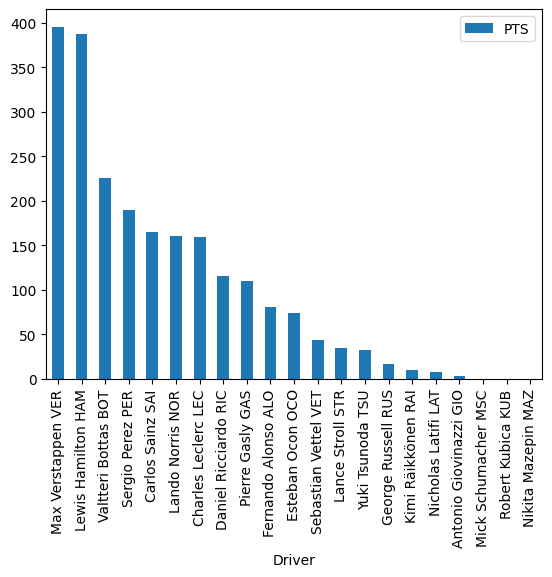

In [4]:
df.plot.bar(x="Driver", y="PTS")

# Race Results

In [5]:
#Bahrain Race 2021 Results
source = urllib.request.urlopen("https://www.formula1.com/en/results.html/2021/races/1064/bahrain/race-result.html").read()
soup = bs.BeautifulSoup(source, 'html.parser')  # Specify 'html.parser' explicitly

table = soup.find_all('table')[0]
html_table = str(table)  # Convert the BeautifulSoup object to an HTML string
df = pd.read_html(io.StringIO(html_table), header=[0])[0]  # Use io.StringIO to wrap the HTML string
df.drop(["Unnamed: 0", "Unnamed: 8"], axis=1, inplace=True)
df.head()

,Pos,No,Driver,Car,Laps,Time/Retired,PTS
0,1,44,Lewis Hamilton HAM,Mercedes,56,1:32:03.897,25
1,2,33,Max Verstappen VER,Red Bull Racing Honda,56,+0.745s,18
2,3,77,Valtteri Bottas BOT,Mercedes,56,+37.383s,16
3,4,4,Lando Norris NOR,McLaren Mercedes,56,+46.466s,12
4,5,11,Sergio Perez PER,Red Bull Racing Honda,56,+52.047s,10


# Seasonal Analysis

In [6]:
HOMEPAGE = 'https://www.formula1.com/'
YEAR = '2021'

In [7]:
# Function to retrieve a list of race URLs for a given year

@timer
def get_race_urls(year):
    # Initialize an empty list to store the race URLs
    race_urls = []

    # Fetch the HTML content from the Formula 1 website for a specific year's race results
    source = urllib.request.urlopen(f"https://www.formula1.com/en/results.html/{YEAR}/races.html").read()

    # Parse the HTML content using BeautifulSoup with the 'html.parser' parser
    soup = bs.BeautifulSoup(source, 'html.parser') 

    # Iterate through all 'a' tags in the HTML content
    for url in soup.find_all('a'):
        # Check if the URL contains the specified year and 'race-result' in its href attribute
        if str(year) in str(url.get('href')) and 'race-result' in str(url.get('href')):
            # Append the URL to the list of race URLs if it's not already in the list
            if url.get('href') not in race_urls:
                race_urls.append(url.get('href'))
    
    # Return the list of race URLs
    return race_urls

get_race_urls(YEAR)

get_race_urls ran in: 0.865 seconds


['/en/results.html/2021/races/1064/bahrain/race-result.html',
 '/en/results.html/2021/races/1065/italy/race-result.html',
 '/en/results.html/2021/races/1066/portugal/race-result.html',
 '/en/results.html/2021/races/1086/spain/race-result.html',
 '/en/results.html/2021/races/1067/monaco/race-result.html',
 '/en/results.html/2021/races/1068/azerbaijan/race-result.html',
 '/en/results.html/2021/races/1070/france/race-result.html',
 '/en/results.html/2021/races/1092/austria/race-result.html',
 '/en/results.html/2021/races/1071/austria/race-result.html',
 '/en/results.html/2021/races/1072/great-britain/race-result.html',
 '/en/results.html/2021/races/1073/hungary/race-result.html',
 '/en/results.html/2021/races/1074/belgium/race-result.html',
 '/en/results.html/2021/races/1075/netherlands/race-result.html',
 '/en/results.html/2021/races/1076/italy/race-result.html',
 '/en/results.html/2021/races/1077/russia/race-result.html',
 '/en/results.html/2021/races/1078/turkey/race-result.html',
 '/e

In [8]:

race_urls = get_race_urls(YEAR)
season_results_df = pd.DataFrame()  # Initialize with an empty DataFrame

@timer
def seasons_results(race_urls):
    global season_results_df

    for n, race in enumerate(race_urls):
        empty_row = [0] * len(season_results_df.columns) if not season_results_df.empty else []  # Create an empty row structure
        race_name = f"{race.split('/')[6]}_{n}"  # Append a unique identifier to the race name

        results_page = urllib.request.urlopen(f"{HOMEPAGE}{race}").read()
        race_results = bs.BeautifulSoup(results_page, 'html.parser')

        table = race_results.find_all('table')[0]
        df = pd.read_html(StringIO(str(table)), flavor='bs4', header=[0])[0]
        df.drop(["Unnamed: 0", "Unnamed: 8"], axis=1, inplace=True)
        df.set_index('No', inplace=True)

        # Initialize season_results_df on the first race information
        if n == 0:
            season_results_df = pd.DataFrame(df[['Driver', 'Car']], columns=['Driver', 'Car'], index=df.index)

        # Add drivers if they are not in season_results_df
        for ind in df.index.difference(season_results_df.index):
            empty_row_copy = empty_row.copy()
            empty_row_copy[:2] = [df['Driver'].loc[ind], df['Car'].loc[ind]]
            season_results_df.loc[ind] = empty_row_copy

        for ind in df.index:
            pts = df['PTS'].where(df.index == ind).dropna().values[0]
            season_results_df.loc[ind, race_name] = int(pts)

    # Format the dataframe with a few lines
    season_results_df.sort_index(inplace=True)
    season_results_df.fillna(0, inplace=True)
    season_results_df['Car'] = season_results_df['Car'].apply(lambda s: s[:3]).map(str.upper)  # retain last 3 digits and caps
    return season_results_df



get_race_urls ran in: 1.022 seconds


In [9]:
season_results_df = seasons_results(race_urls)
season_results_df

seasons_results ran in: 17.788 seconds


,Driver,Car,bahrain_0,italy_1,portugal_2,spain_3,monaco_4,azerbaijan_5,france_6,austria_7,...,netherlands_12,italy_13,russia_14,turkey_15,united-states_16,mexico_17,brazil_18,qatar_19,saudi-arabia_20,abu-dhabi_21
No,,,,,,,,,,,,,,,,,,,,,
3,Daniel Ricciardo RIC,MCL,6.0,8.0,2.0,8.0,0.0,2.0,8.0,0.0,...,0.0,26.0,12.0,0.0,10.0,0.0,0.0,0.0,10.0,0.0
4,Lando Norris NOR,MCL,12.0,15.0,10.0,4.0,15.0,10.0,10.0,10.0,...,1.0,18.0,7.0,6.0,4.0,1.0,1.0,2.0,1.0,6.0
5,Sebastian Vettel VET,AST,0.0,0.0,0.0,0.0,10.0,18.0,2.0,0.0,...,0.0,0.0,0.0,0.0,1.0,6.0,0.0,1.0,0.0,0.0
6,Nicholas Latifi LAT,WIL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Kimi Räikkönen RAI,ALF,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
9,Nikita Mazepin MAZ,HAA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,Pierre Gasly GAS,ALP,0.0,6.0,1.0,1.0,8.0,15.0,6.0,0.0,...,12.0,0.0,0.0,8.0,0.0,12.0,6.0,0.0,8.0,10.0
11,Sergio Perez PER,RED,10.0,0.0,12.0,10.0,12.0,25.0,15.0,12.0,...,4.0,10.0,2.0,15.0,15.0,15.0,13.0,12.0,0.0,0.0
14,Fernando Alonso ALO,ALP,0.0,1.0,4.0,0.0,0.0,8.0,4.0,2.0,...,8.0,4.0,8.0,0.0,0.0,2.0,2.0,15.0,0.0,4.0


In [10]:
total_results = season_results_df.drop(['Driver', 'Car'], axis=1).cumsum(axis=1)

In [11]:
total_results['Driver'] = season_results_df['Driver'].apply(lambda s : s[-3:]).map(str.upper)
total_results.sort_values(by='abu-dhabi_21',ascending=False, inplace=True)
total_results.set_index('Driver', inplace=True)
total_results

,bahrain_0,italy_1,portugal_2,spain_3,monaco_4,azerbaijan_5,france_6,austria_7,austria_8,great-britain_9,...,netherlands_12,italy_13,russia_14,turkey_15,united-states_16,mexico_17,brazil_18,qatar_19,saudi-arabia_20,abu-dhabi_21
Driver,,,,,,,,,,,,,,,,,,,,,
VER,18.0,43.0,61.0,80.0,105.0,105.0,131.0,156.0,182.0,182.0,...,221.0,221.0,239.0,257.0,282.0,307.0,325.0,344.0,362.0,388.0
HAM,25.0,44.0,69.0,94.0,101.0,101.0,119.0,138.0,150.0,175.0,...,219.0,219.0,244.0,254.0,273.0,291.0,316.0,341.0,367.0,385.0
BOT,16.0,16.0,32.0,47.0,47.0,47.0,59.0,74.0,92.0,107.0,...,122.0,137.0,147.0,173.0,181.0,181.0,196.0,196.0,211.0,219.0
PER,10.0,10.0,22.0,32.0,44.0,69.0,84.0,96.0,104.0,104.0,...,108.0,118.0,120.0,135.0,150.0,165.0,178.0,190.0,190.0,190.0
SAI,4.0,14.0,14.0,20.0,38.0,42.0,42.0,50.0,60.0,68.0,...,89.0,97.0,112.0,116.0,122.0,130.0,138.0,144.0,148.0,163.0
NOR,12.0,27.0,37.0,41.0,56.0,66.0,76.0,86.0,101.0,113.0,...,114.0,132.0,139.0,145.0,149.0,150.0,151.0,153.0,154.0,160.0
LEC,8.0,20.0,28.0,40.0,40.0,52.0,52.0,58.0,62.0,80.0,...,92.0,104.0,104.0,116.0,128.0,138.0,148.0,152.0,158.0,159.0
RIC,6.0,14.0,16.0,24.0,24.0,26.0,34.0,34.0,40.0,50.0,...,56.0,82.0,94.0,94.0,104.0,104.0,104.0,104.0,114.0,114.0
GAS,0.0,6.0,7.0,8.0,16.0,31.0,37.0,37.0,39.0,39.0,...,66.0,66.0,66.0,74.0,74.0,86.0,92.0,92.0,100.0,110.0


Text(0, 0.5, 'Points')

<Figure size 1400x800 with 0 Axes>

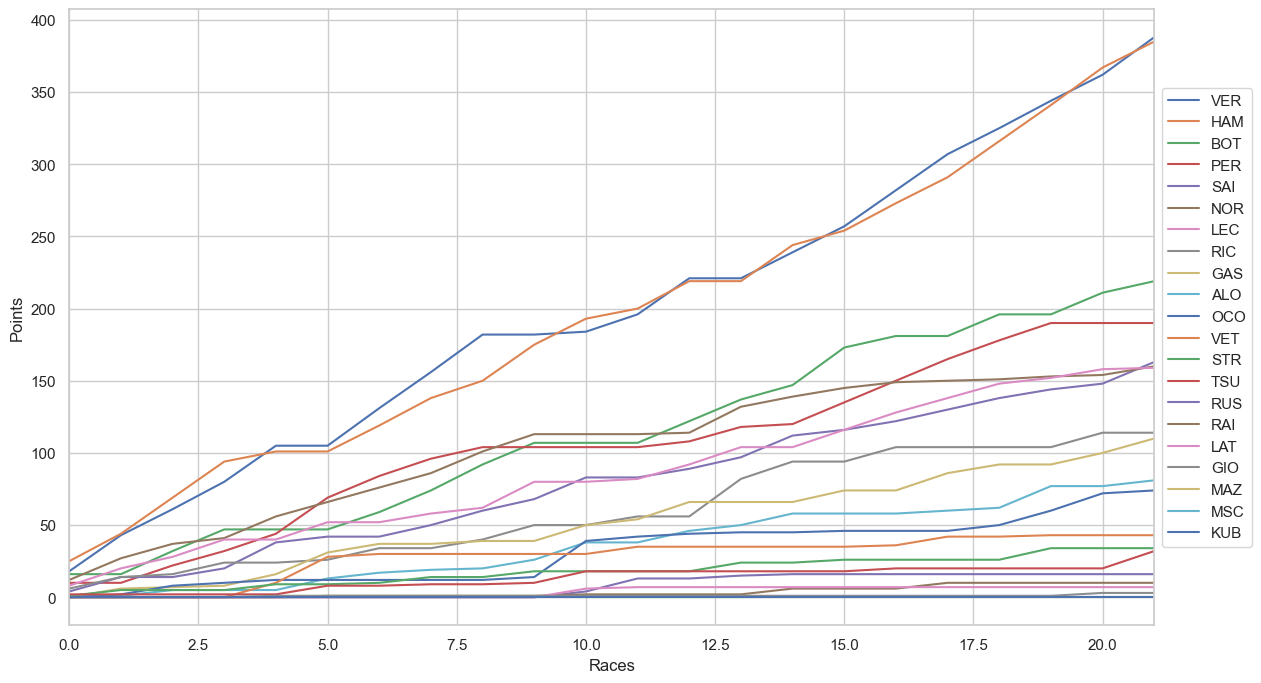

In [12]:
fig = plt.figure(figsize=(14,8))
#ax = fig.add_subplot(1, 1, 1) 
sns.set(style='whitegrid')

total_results.transpose().plot.line(figsize=(14,8),use_index=False, xlim=(0,21)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.xlabel("Races")
plt.ylabel("Points")
#plt.savefig(f"{path}/cum1990.png", dpi=300)

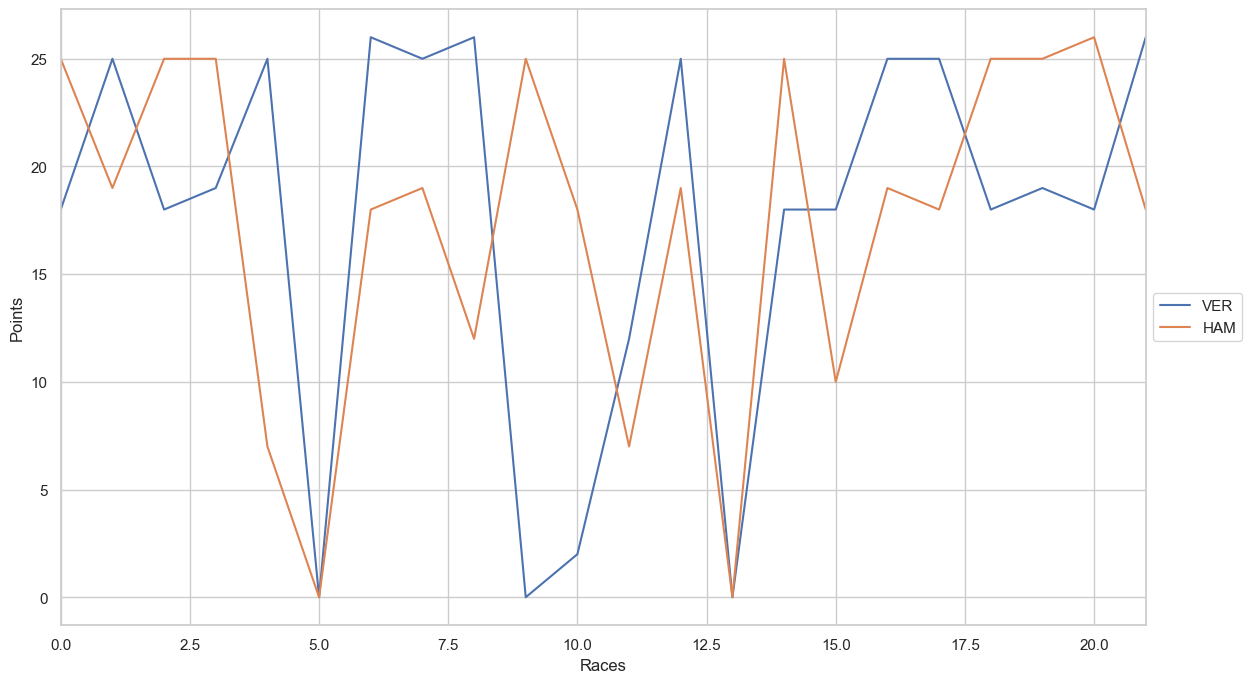

In [13]:

# Manipulate DataFrame
season_results_df['Driver'] = season_results_df['Driver'].apply(lambda s: s[-3:]).map(str.upper)
season_results_df.sort_values(by='abu-dhabi_21', ascending=False, inplace=True)
season_results_df.set_index('Driver', inplace=True)
season_results_df.drop('Car', axis=1, inplace=True)

# Filter data for Hamilton and Verstappen
drivers_to_plot = ['HAM', 'VER']
filtered_df = season_results_df[season_results_df.index.isin(drivers_to_plot)]

# Plotting
fig, ax = plt.subplots(figsize=(14, 8))
sns.set(style='whitegrid')

# Plot lines for Hamilton and Verstappen
filtered_df.transpose().plot.line(figsize=(14, 8), use_index=False, ax=ax, xlim=(0, 21))

# Set legend position
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

# Set axis labels
plt.xlabel("Races")
plt.ylabel("Points")

# Show the plot
plt.show()




req         WARNING 	

DEFAULT CACHE ENABLED!
	Cache directory: C:\Users\Harnoor Singh\AppData\Local\Temp\fastf1.
	Size: 237.73 MB
core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v3.1.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 9
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 9)
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '55', '22', '10', '77', '4', '14', '31', '16', '5',

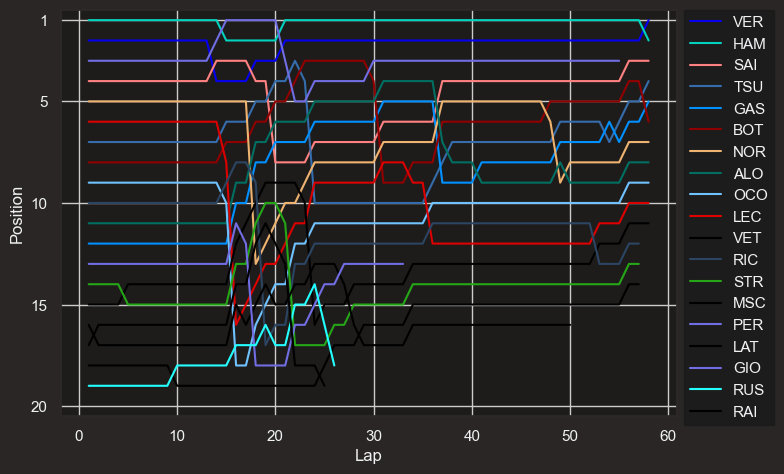

In [14]:
import fastf1
import fastf1.plotting
import matplotlib.pyplot as plt

fastf1.plotting.setup_mpl(misc_mpl_mods=False)

session = fastf1.get_session(2021, 22, 'R')
session.load(telemetry=False, weather=False)

fig, ax = plt.subplots(figsize=(8.0, 4.9))

for drv in session.drivers:
    drv_laps = session.laps.pick_driver(drv)

    if not drv_laps.empty:
        abb = drv_laps['Driver'].iloc[0]

        try:
            color = fastf1.plotting.driver_color(abb)
        except KeyError:
            color = 'black'  # Assign a default color if the driver's color is not found

        ax.plot(drv_laps['LapNumber'], drv_laps['Position'],
                label=abb, color=color)

ax.set_ylim([20.5, 0.5])
ax.set_yticks([1, 5, 10, 15, 20])
ax.set_xlabel('Lap')
ax.set_ylabel('Position')

ax.legend(bbox_to_anchor=(1.0, 1.02))
plt.tight_layout()

plt.show()
